The following code block imports libraries we will be using.

In [1]:
import pathlib
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

The following code block reads all records from the `Orders` table in the `northwind.db` file. **Note:** the `northwind.db` file should be in the same folder as this notebook. 

In [2]:
with sqlite3.Connection('northwind.db') as conn:
    orders = pd.read_sql('SELECT * FROM Orders', conn)
orders.head()

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2016-07-04,2016-08-01,2016-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2016-07-08,2016-08-05,2016-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2016-07-08,2016-08-05,2016-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2016-07-09,2016-08-06,2016-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


The following code block show how we could select a subset of columns (`OrderID` and `CustomerID`) from the `Orders` table in the `northwind.db` file.

In [3]:
with sqlite3.Connection('northwind.db') as conn:
    temp = pd.read_sql('SELECT OrderID, CustomerID FROM Orders', conn)
temp.head()

,OrderID,CustomerID
0,10248,VINET
1,10249,TOMSP
2,10250,HANAR
3,10251,VICTE
4,10252,SUPRD


The following code block reads all records from the `Order Details` table in the `northwind.db` file. **Note:** we need to use double quotation marks because the table name includes a space.

In [4]:
with sqlite3.Connection('northwind.db') as conn:
    order_details = pd.read_sql('SELECT * FROM "Order Details"', conn)
order_details.head(5)

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


The following code block computes the number of products (total quantity) for each order and the number of unique product ids for each order. **Note:** the `reset_index()` call at the end brings the `index` of the aggregated data, which is the column(s) specified in the `groupby` function in as column and creates a new index that is sequential integers.

In [5]:
product_summary = order_details.groupby(
    'OrderID',
).agg(
    total_quantity=('Quantity', 'sum'),
    unique_producs=('ProductID', 'nunique'),
).reset_index()

product_summary.head()

,OrderID,total_quantity,unique_producs
0,10248,27,3
1,10249,49,2
2,10250,60,3
3,10251,41,3
4,10252,105,3


The following code block uses the `merge` method of a `pandas` `DataFrame` to merge the `orders` and `product_summary` objects. **Note:** We use `merge` because the two `DataFrame` objects have a common column (`OrderID`). If the index values were identifcal, we would use the `join` method.

In [6]:
orders = orders.merge(product_summary)
orders.head()

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,total_quantity,unique_producs
0,10248,VINET,5,2016-07-04,2016-08-01,2016-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,Western Europe,51100,France,27,3
1,10249,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,49,2
2,10250,HANAR,4,2016-07-08,2016-08-05,2016-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,60,3
3,10251,VICTE,3,2016-07-08,2016-08-05,2016-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,41,3
4,10252,SUPRD,4,2016-07-09,2016-08-06,2016-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,105,3


Soon, we will be looking into things that are predictive of late orders. With the information we are given in the `orders` data, we know an order was late if the date in the `ShippedDate` column is later than that in the `RequiredDate` column. The following code block converts the values in these columns to `datetime64` objetcs.

In [7]:
orders['RequiredDate'] = pd.to_datetime(orders['RequiredDate'])
orders['ShippedDate'] = pd.to_datetime(orders['ShippedDate'])

Printing the dtypes confirms the conversion worked.

In [8]:
orders.dtypes

OrderID                    int64
CustomerID                object
EmployeeID                 int64
OrderDate                 object
RequiredDate      datetime64[ns]
ShippedDate       datetime64[ns]
ShipVia                    int64
Freight                  float64
ShipName                  object
ShipAddress               object
ShipCity                  object
ShipRegion                object
ShipPostalCode            object
ShipCountry               object
total_quantity             int64
unique_producs             int64
dtype: object

The following code block adds a column to the `orders` `DataFrame` that specifies whether orders are late (1) or not (0). Note that our definition of late is that an order ships after the date specified in the `RequiredDate` column. We don't have delivery date information, so this is the best we can do.

In [9]:
late_mask = orders['ShippedDate'] > orders['RequiredDate']
orders['late'] = late_mask.astype(int)

The following code block creates a new column in the `orders` `DataFrame` that captures the number of days that an order ships before the required date. Positive values indicate that an order was shipped before the required date and negative values indicate that an order shipped after the required date.

In [10]:
shipped_before_due = orders['RequiredDate'] - orders['ShippedDate']
orders['shipped_before_due'] = shipped_before_due/pd.Timedelta(days=1)

The following code block shows how we can use `matplotlib` and `pandas` to plot a histogram of the data in the `shipped_before_due` column.

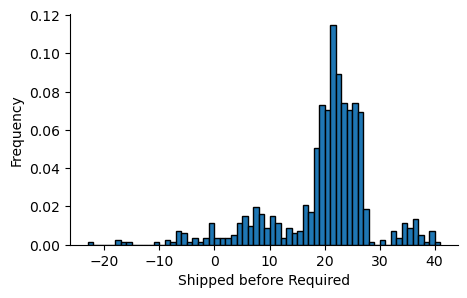

In [11]:
fig, nicks_ax = plt.subplots(1, 1, figsize=(5, 3))

orders['shipped_before_due'].plot(
    kind='hist',
    edgecolor='k',
    density=True,
    bins=range(-23, 42),
    ax=nicks_ax,
)
nicks_ax.spines[['top', 'right']].set_visible(False)
nicks_ax.set_xlabel('Shipped before Required')

plt.show()

The following code block shows how we can use `matplotlib` and `pandas` to plot a barplot that shows the proportion of late items by the number of unique products composing an order.

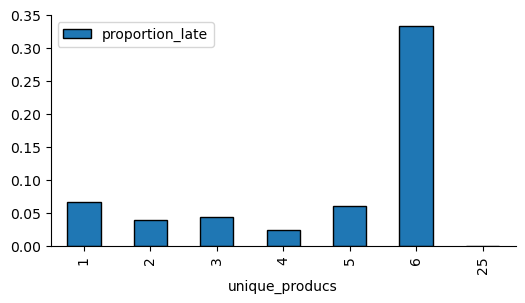

In [12]:
fig, nicks_ax2 = plt.subplots(1, 1, figsize=(6, 3))

orders.groupby('unique_producs').agg(
    proportion_late=('late', 'mean')
).plot(
    kind='bar',
    y='proportion_late',
    edgecolor='k',
    ax=nicks_ax2,
)
nicks_ax2.spines[['top', 'right']].set_visible(False)

plt.show()

The following code block combines the previous two plots into a single figure (1 row, 2 columns). Note that the axes object returned here is a `numpy` `array`, so I have to index the array for each subplot to place them on the correct axis.

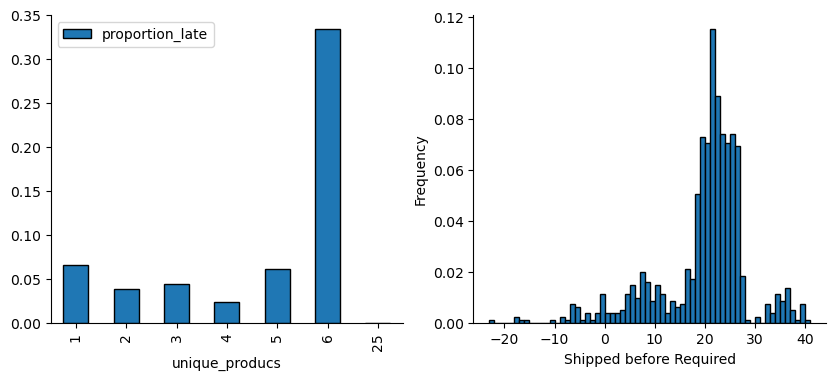

In [13]:
fig, nicks_ax = plt.subplots(1, 2, figsize=(10, 4))

orders.groupby('unique_producs').agg(
    proportion_late=('late', 'mean')
).plot(
    kind='bar',
    y='proportion_late',
    edgecolor='k',
    ax=nicks_ax[0],
)
nicks_ax[0].spines[['top', 'right']].set_visible(False)


orders['shipped_before_due'].plot(
    kind='hist',
    edgecolor='k',
    density=True,
    bins=range(-23, 42),
    ax=nicks_ax[1],
)
nicks_ax[1].spines[['top', 'right']].set_visible(False)
nicks_ax[1].set_xlabel('Shipped before Required')

plt.show()

The following code block expands the previous figure to include a new row. Now our figure is setup for 2 rows and 2 columns. As a result, axes object returned here is a `numpy` `array` of dimension 2 x 2. So, when specifiying the axis for a specific plot, I have to include both a row index and a column index.

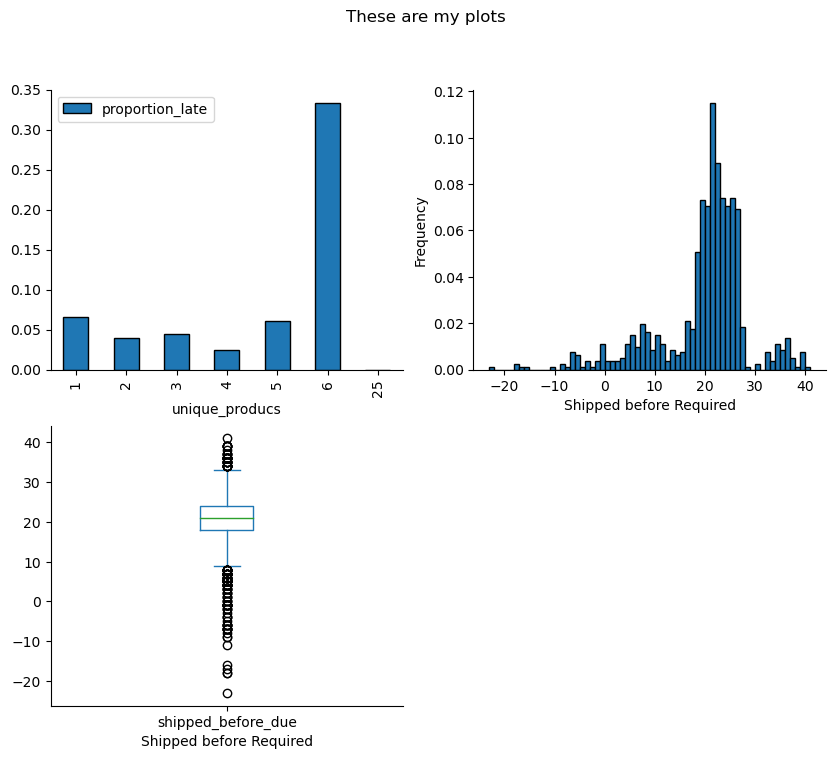

In [14]:
fig, nicks_ax = plt.subplots(2, 2, figsize=(10, 8))

orders.groupby('unique_producs').agg(
    proportion_late=('late', 'mean')
).plot(
    kind='bar',
    y='proportion_late',
    edgecolor='k',
    ax=nicks_ax[0, 0],
)
nicks_ax[0, 0].spines[['top', 'right']].set_visible(False)


orders['shipped_before_due'].plot(
    kind='hist',
    edgecolor='k',
    density=True,
    bins=range(-23, 42),
    ax=nicks_ax[0, 1],
)
nicks_ax[0, 1].spines[['top', 'right']].set_visible(False)
nicks_ax[0, 1].set_xlabel('Shipped before Required')

orders['shipped_before_due'].plot(
    kind='box',
    x='shipped_before_due',
    ax=nicks_ax[1, 0],
)
nicks_ax[1, 0].spines[['top', 'right']].set_visible(False)
nicks_ax[1, 0].set_xlabel('Shipped before Required')

nicks_ax[1, 1].axis('off')

fig.suptitle('These are my plots')

plt.show()